In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split

import zipfile

In [2]:
# --- SET SEED FOR REPRODUCIBILITY ---
SEED = 42  # фиксируем seed для полной воспроизводимости
torch.manual_seed(SEED)  # фиксируем seed для PyTorch
random.seed(SEED)        # фиксируем seed для Python random
np.random.seed(SEED)     # фиксируем seed для NumPy
torch.backends.cudnn.deterministic = True  # гарантирует детерминированность на GPU
torch.backends.cudnn.benchmark = False     # отключаем autotuner, чтобы не влиял на детерминированность

# --- CONFIGURATION ---
# --- DOWNLOAD ZIP FROM GOOGLE DRIVE ---
output = 'data_full.zip'
unzip_dir = 'unzipped_data_full'

if not os.path.exists(unzip_dir):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

data_dir = 'unzipped_data_full/data_full'
batch_size = 8                 # количество изображений в одном батче
num_epochs = 20                # сколько раз модель проходит весь датасет
val_split = 0.2                # доля валидационных данных (20%)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # автоматический выбор CUDA или CPU
device

device(type='cuda')

In [3]:
# --- PREPROCESSING ---
weights = ResNet18_Weights.DEFAULT  # используем предобученные веса ImageNet
mean, std = weights.transforms().mean, weights.transforms().std  # стандартизация под ImageNet

# трансформации для тренировочной выборки (с аугментациями)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                          # приводим все изображения к 224x224
    transforms.RandomHorizontalFlip(p=0.5),                 # случайный поворот по горизонтали
    transforms.RandomRotation(20),                          # случайный поворот на ±20 градусов
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.9, 1.1)),  # аффинные преобразования
    transforms.ColorJitter(brightness=0.4, contrast=0.4),   # случайные изменения яркости и контраста
    transforms.ToTensor(),                                  # перевод в тензор [C, H, W]
    transforms.Normalize(mean, std),                        # нормализация под ImageNet
])

# трансформации для валидационной выборки (без аугментаций)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- DATASET ---
full_dataset = datasets.ImageFolder(data_dir)   # читаем датасет: каждая папка = один класс
class_names = full_dataset.classes              # сохраняем список классов

val_size = int(len(full_dataset) * val_split)   # размер валидационной выборки
train_size = len(full_dataset) - val_size       # размер тренировочной выборки

# фиксированный random_split с генератором (для стабильного train/val деления)
generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# применяем трансформации
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# создаём батчеры
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # перемешиваем батчи на тренировке
val_loader = DataLoader(val_dataset, batch_size=batch_size)                    # валидация — без shuffle

# --- MODEL ---
model = resnet18(weights=weights)  # загружаем предобученную модель ResNet18

model.fc = nn.Linear(model.fc.in_features, len(class_names))  # переопределяем выходной слой под свои классы
model = model.to(device)  # отправляем модель на GPU/CPU

criterion = nn.CrossEntropyLoss()  # функция потерь: кросс-энтропия для классификации
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Adam — адаптивный оптимизатор
# lr — learning rate (скорость обучения)
# weight_decay — L2-регуляризация (борьба с переобучением)

# --- TRAINING LOOP ---
train_losses, val_accuracies = [], []  # для графиков
best_val_acc = 0.0                     # трекинг лучшей валидации

for epoch in range(num_epochs):  # цикл по эпохам
    model.train()  # режим обучения (вкл. Dropout, BatchNorm)
    total_loss, correct, total = 0.0, 0, 0  # сбрасываем метрики

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()             # обнуляем градиенты
        outputs = model(images)          # делаем предсказание
        loss = criterion(outputs, labels)  # вычисляем loss
        loss.backward()                  # обратное распространение ошибки
        optimizer.step()                 # обновляем веса

        total_loss += loss.item() * images.size(0)  # накапливаем потери
        _, preds = torch.max(outputs, 1)            # получаем предсказанные классы
        correct += (preds == labels).sum().item()   # сколько предсказаний правильны
        total += labels.size(0)                     # общее количество примеров

    train_acc = correct / total                     # точность на тренировке
    avg_loss = total_loss / total                   # средняя потеря на тренировке
    train_losses.append(avg_loss)                   # логируем
    model.eval()                                    # режим валидации (выкл. Dropout, BatchNorm)

    val_correct, val_total = 0, 0
    with torch.no_grad():  # не вычисляем градиенты
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Сохраняем модель, если она самая точная на валидации
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')  # сохраняем только веса
        print(f"✅ Saved best model at epoch {epoch+1} with val_acc: {val_acc:.4f}")

Epoch [1/20], Loss: 1.1869, Train Acc: 0.4563, Val Acc: 0.4510
✅ Saved best model at epoch 1 with val_acc: 0.4510
Epoch [2/20], Loss: 0.5294, Train Acc: 0.8204, Val Acc: 0.6078
✅ Saved best model at epoch 2 with val_acc: 0.6078
Epoch [3/20], Loss: 0.2452, Train Acc: 0.9417, Val Acc: 0.7255
✅ Saved best model at epoch 3 with val_acc: 0.7255
Epoch [4/20], Loss: 0.1026, Train Acc: 0.9951, Val Acc: 0.6667
Epoch [5/20], Loss: 0.1168, Train Acc: 0.9660, Val Acc: 0.6863
Epoch [6/20], Loss: 0.0988, Train Acc: 0.9709, Val Acc: 0.7255
Epoch [7/20], Loss: 0.0734, Train Acc: 0.9854, Val Acc: 0.7059
Epoch [8/20], Loss: 0.1292, Train Acc: 0.9660, Val Acc: 0.6471
Epoch [9/20], Loss: 0.0584, Train Acc: 0.9903, Val Acc: 0.7255
Epoch [10/20], Loss: 0.0368, Train Acc: 0.9951, Val Acc: 0.7059
Epoch [11/20], Loss: 0.0259, Train Acc: 1.0000, Val Acc: 0.6667
Epoch [12/20], Loss: 0.0129, Train Acc: 1.0000, Val Acc: 0.7255
Epoch [13/20], Loss: 0.0475, Train Acc: 0.9903, Val Acc: 0.5490
Epoch [14/20], Loss: 0.0

In [4]:
sample_img, label = val_dataset[0]
print(sample_img.shape)
sample_img

torch.Size([3, 224, 224])


tensor([[[0.2796, 0.2796, 0.2967,  ..., 0.4508, 0.4679, 0.4679],
         [0.2796, 0.2796, 0.2796,  ..., 0.4337, 0.4508, 0.4508],
         [0.2624, 0.2624, 0.2624,  ..., 0.4337, 0.4337, 0.4508],
         ...,
         [0.1768, 0.1768, 0.1939,  ..., 0.2796, 0.2967, 0.3138],
         [0.1768, 0.1768, 0.1939,  ..., 0.2796, 0.2967, 0.3138],
         [0.1768, 0.1768, 0.1768,  ..., 0.2796, 0.2967, 0.3138]],

        [[0.4153, 0.4153, 0.4328,  ..., 0.5903, 0.6078, 0.6078],
         [0.4153, 0.4153, 0.4153,  ..., 0.5728, 0.5903, 0.5903],
         [0.3978, 0.3978, 0.3978,  ..., 0.5728, 0.5728, 0.5903],
         ...,
         [0.3102, 0.3102, 0.3277,  ..., 0.4153, 0.4328, 0.4503],
         [0.3102, 0.3102, 0.3277,  ..., 0.4153, 0.4328, 0.4503],
         [0.3102, 0.3102, 0.3102,  ..., 0.4153, 0.4328, 0.4503]],

        [[0.6356, 0.6356, 0.6531,  ..., 0.8099, 0.8274, 0.8274],
         [0.6356, 0.6356, 0.6356,  ..., 0.7925, 0.8099, 0.8099],
         [0.6182, 0.6182, 0.6182,  ..., 0.7925, 0.7925, 0.

In [5]:
class_names

['Bosmina longirostris Europe adult',
 'Bosmina longirostris Europe juvinile',
 'Bosmina sp nov. Sakhalin adult',
 'Bosmina sp nov. Sakhalin juvinile']

In [6]:
len(val_dataset)

51

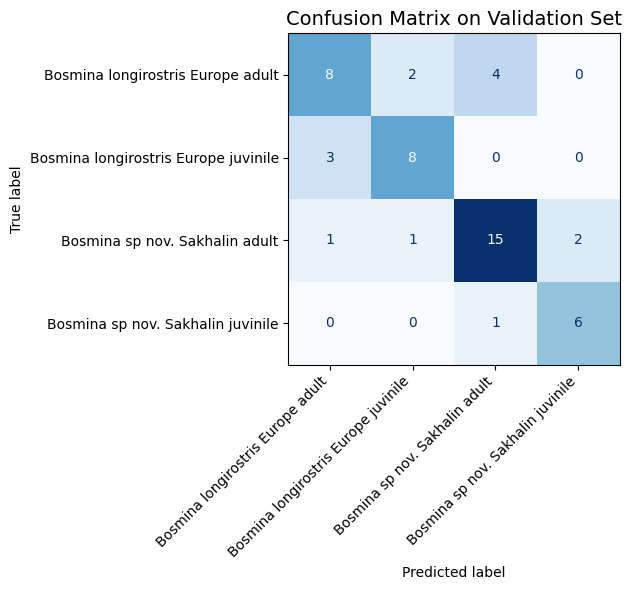

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)

ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')

ax.set_title("Confusion Matrix on Validation Set", fontsize=14)
plt.tight_layout()
plt.show()


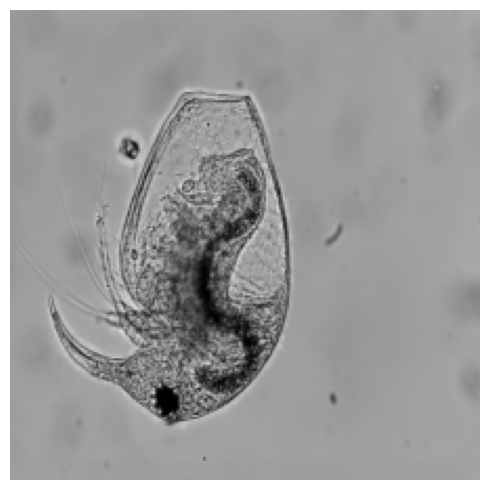

In [14]:
from utils import *

def plot(img):
    plt.figure(figsize=(15, 5))
    plt.axis('off')
    tensor_imshow(img[0].cpu())
    plt.tight_layout()
    plt.show()

sample_img, label = val_dataset[49]
sample_img = sample_img.unsqueeze(0).to(device) 
plot(sample_img)